# Ivancich Stefano 1227846
# HOMEWORK 2





In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

### Set the random seed for reproducible results
torch.manual_seed(0)

Training device: cuda


# 1) Dataset

In [2]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

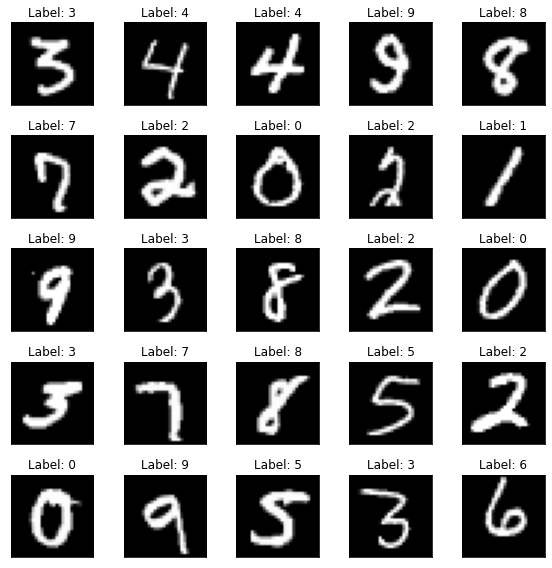

In [3]:
### Plot some sample
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## 1.1) Dataset Transform

In [4]:
class noise(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        noise_factor=0.1*3
        noisy_img = image + noise_factor * torch.randn(image.shape)
        #clip the image
        noisy_img = np.clip(noisy_img, 0., 1.)

        return (image,noisy_img)

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    noise(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    noise(),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    noise(),
])

In [6]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

## 1.2) Dataloader

In [7]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
#test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


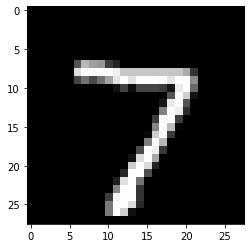

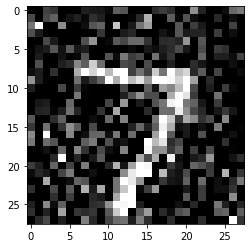

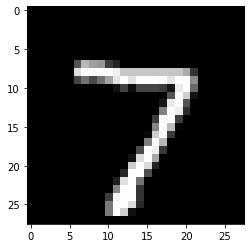

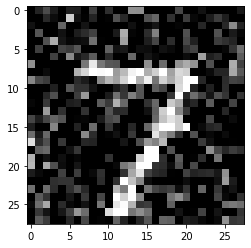

In [8]:
#Check if the transformation works
for image in test_dataloader:
    
    plt.imshow(image[0][0][0][0],cmap='gray')
    plt.show()
    plt.close()
    plt.imshow(image[0][1][0][0],cmap='gray')
    plt.show()
    plt.close()
    
    break


img=test_dataset[0][0][0].unsqueeze(0).to(device)
plt.imshow(img.cpu().squeeze().numpy(),cmap='gray')
plt.show()

img=test_dataset[0][0][1].unsqueeze(0).to(device)
plt.imshow(img.cpu().squeeze().numpy(),cmap='gray')
plt.show()



# 2) Model

## 2.1) Encoder

In [9]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,dropout=0.5, conv1=8,conv2=16,conv3=32,fc=64):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, conv1, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Second convolutional layer
            nn.Conv2d(conv1, conv2, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Third convolutional layer
            nn.Conv2d(conv2, conv3, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)#dimension 0 is the sample, so we flatten from dimension 1

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * conv3, fc),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            # Second linear layer
            nn.Linear(fc, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

## 2.2) Decoder

In [10]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,dropout=0.5, conv1=8,conv2=16,conv3=32,fc=64):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            # Second linear layer
            nn.Linear(fc, 3 * 3 * conv3),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(conv3, conv2, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Second transposed convolution
            nn.ConvTranspose2d(conv2, conv1, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Dropout2d(p=dropout),
            # Third transposed convolution
            nn.ConvTranspose2d(conv1, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

# 3) Train

## 3.1) Training Functions

In [11]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer,noise=False):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        
        image= image_batch[0].to(device)
        
        noisy=image    
        if noise: 
            noisy=image_batch[1].to(device)

        # Encode data
        encoded_data = encoder(noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
    return loss.data

In [12]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn,noise=False):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image= image_batch[0].to(device)
        
            noisy=image
            
            if noise: 
                noisy=image_batch[1].to(device)
                
            # Encode data
            encoded_data = encoder(noisy)
            
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image.cpu())

        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [13]:
### Training cycle
def training_cycle(num_epochs,early_stopping,encoder,decoder,loss_fn,optim,train_dataloader,device,test_dataset,noise=False):
    train_loss_log = []
    val_loss_log = []

    max_early=float("-inf")
    idx_early=-1

    for epoch in range(num_epochs):
        #print('\t EPOCH %d/%d' % (epoch + 1, num_epochs))

        ### Training (use the training function)
        train_loss=train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim,
            noise=noise)
        train_loss_log.append(train_loss)
        print('\t TRAIN - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, train_loss))

        ### Validation  (use the testing function)
        val_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn,
            noise=noise)
        val_loss_log.append(val_loss)
        print('\t VALIDATION - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, val_loss))

        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0][0].unsqueeze(0).to(device)
        if noise: img = test_dataset[0][0][1].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(12,6))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)
        # Save figures
        os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
        fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
        plt.show()
        plt.close()

        # Save network parameters
        torch.save(encoder.state_dict(), 'encoder_params.pth')
        torch.save(decoder.state_dict(), 'decoder_params.pth')
        torch.save(optim.state_dict(), 'optim_params.pth')


        #Early stopping:
        if idx_early==-1:
            idx_early=epoch
            max_early=val_loss
        elif round(float(val_loss),3)<round(float(max_early),3):
            idx_early=epoch
            max_early=val_loss
            
        elif epoch-idx_early>=early_stopping:
            print("STOPPED BY EARLY STOPPYNG")
            break
    
    return (train_loss_log,val_loss_log)
    
    

## 3.2) Grid Search

Total Combinations: 1


Iteration: 0 (10, 8, 16, 32, 64, 0.001, 1e-05)
	 TRAIN - EPOCH 1/50 - loss: 0.065992
	 VALIDATION - EPOCH 1/50 - loss: 0.064963


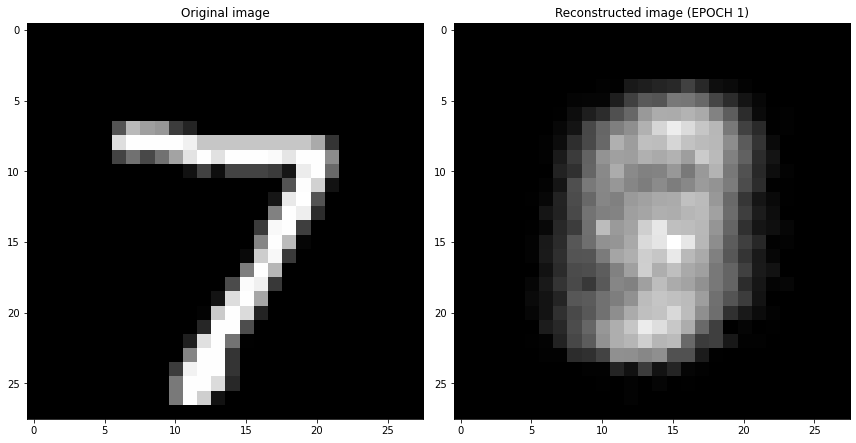

	 TRAIN - EPOCH 2/50 - loss: 0.053796
	 VALIDATION - EPOCH 2/50 - loss: 0.052127


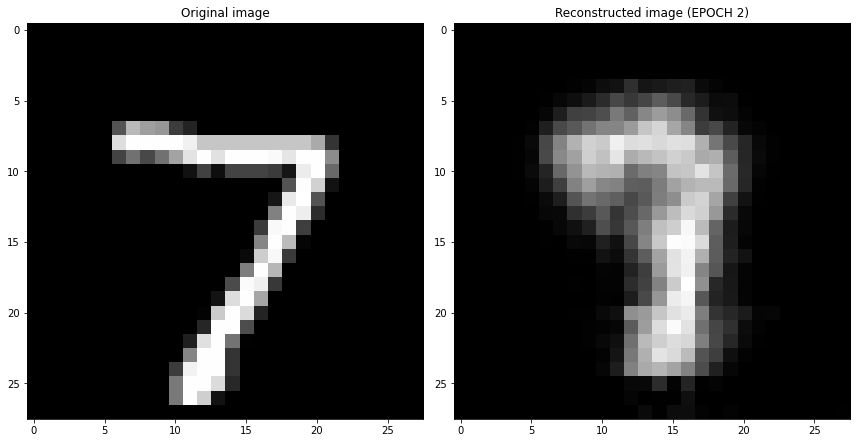

	 TRAIN - EPOCH 3/50 - loss: 0.040042
	 VALIDATION - EPOCH 3/50 - loss: 0.037782


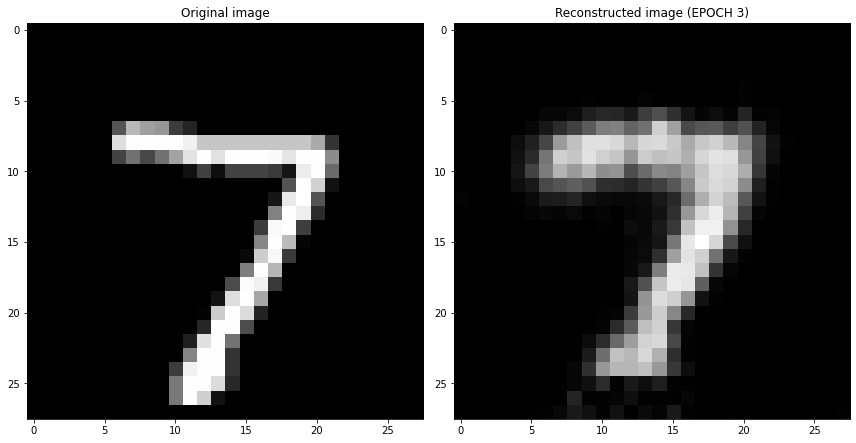

	 TRAIN - EPOCH 4/50 - loss: 0.028790
	 VALIDATION - EPOCH 4/50 - loss: 0.030619


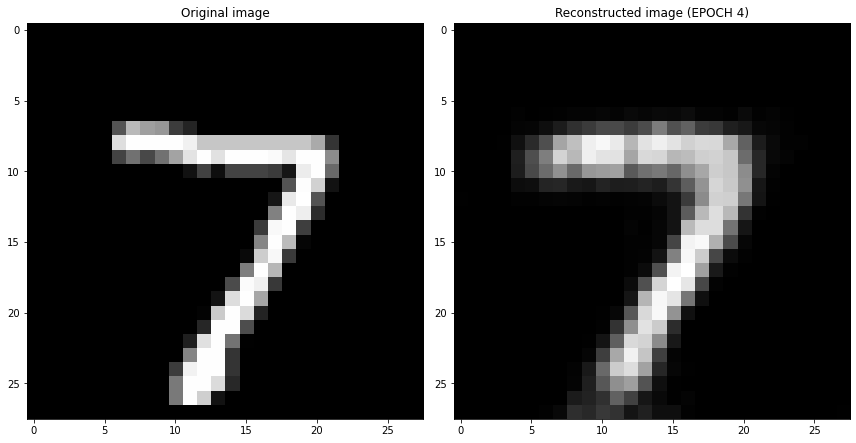

	 TRAIN - EPOCH 5/50 - loss: 0.026019
	 VALIDATION - EPOCH 5/50 - loss: 0.026673


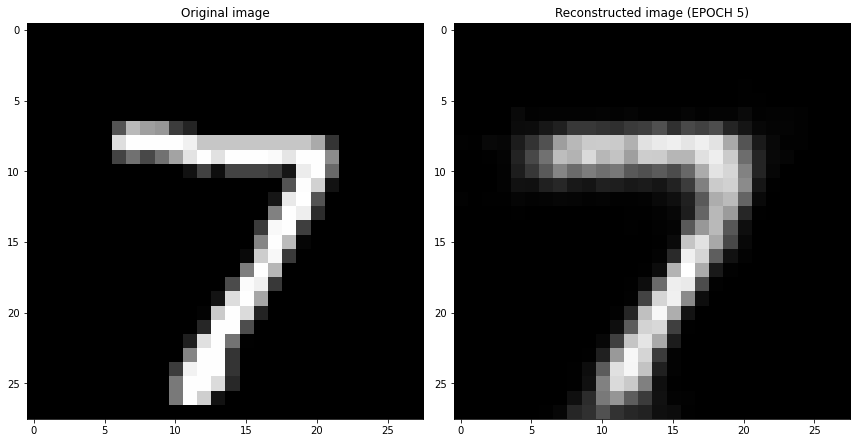

	 TRAIN - EPOCH 6/50 - loss: 0.024348
	 VALIDATION - EPOCH 6/50 - loss: 0.024344


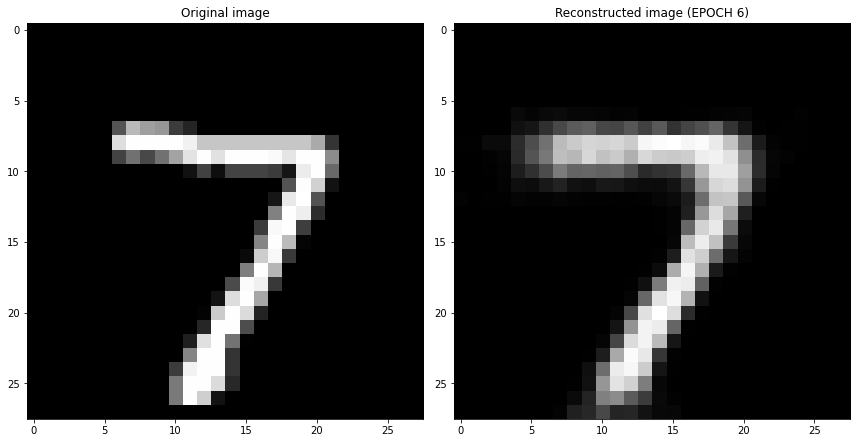

	 TRAIN - EPOCH 7/50 - loss: 0.024605
	 VALIDATION - EPOCH 7/50 - loss: 0.022794


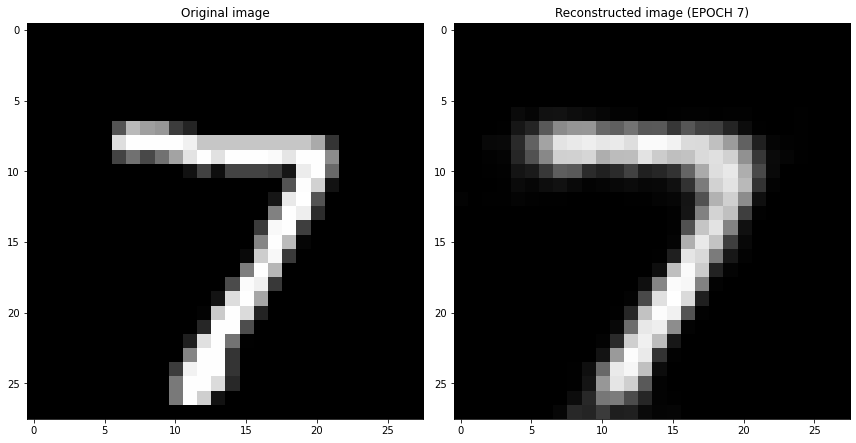

	 TRAIN - EPOCH 8/50 - loss: 0.023031
	 VALIDATION - EPOCH 8/50 - loss: 0.021476


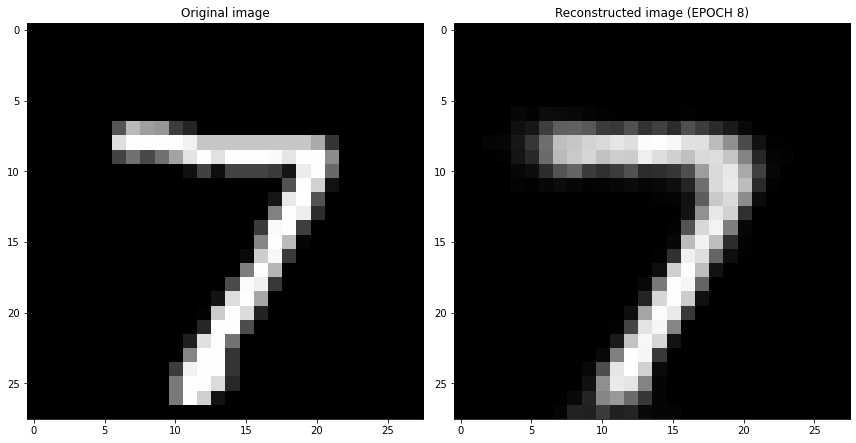

	 TRAIN - EPOCH 9/50 - loss: 0.020227
	 VALIDATION - EPOCH 9/50 - loss: 0.020136


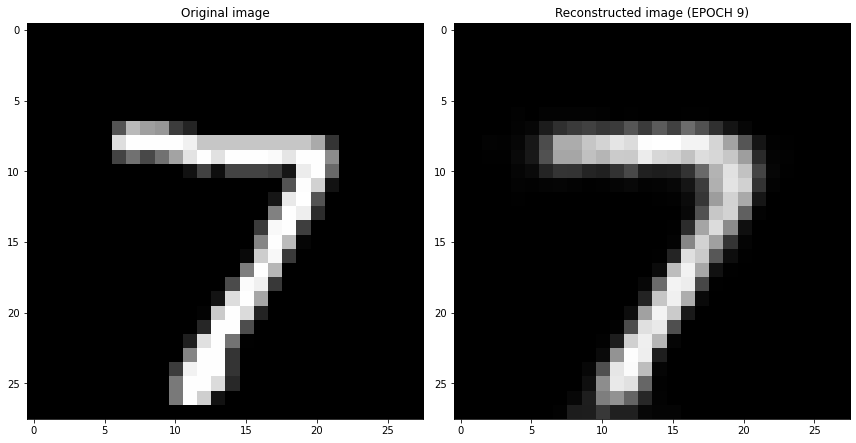

	 TRAIN - EPOCH 10/50 - loss: 0.021455
	 VALIDATION - EPOCH 10/50 - loss: 0.019422


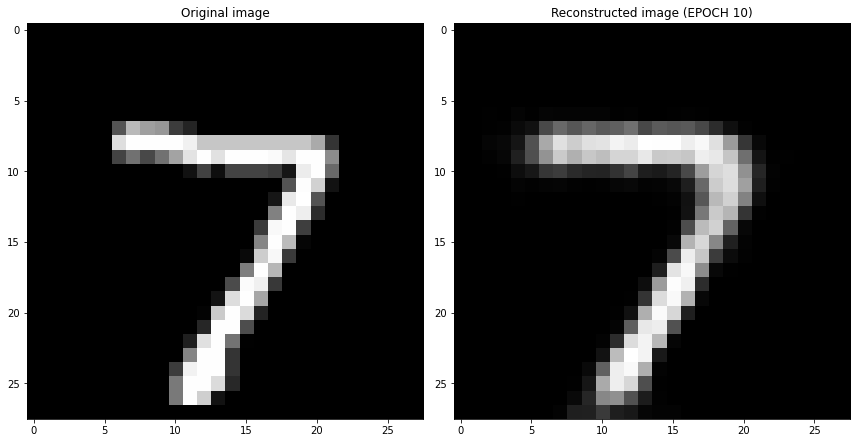

	 TRAIN - EPOCH 11/50 - loss: 0.019087
	 VALIDATION - EPOCH 11/50 - loss: 0.018866


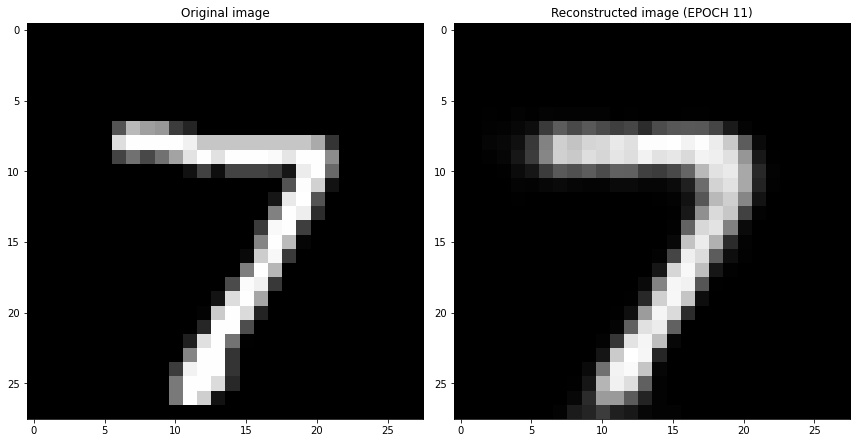

	 TRAIN - EPOCH 12/50 - loss: 0.017705
	 VALIDATION - EPOCH 12/50 - loss: 0.018135


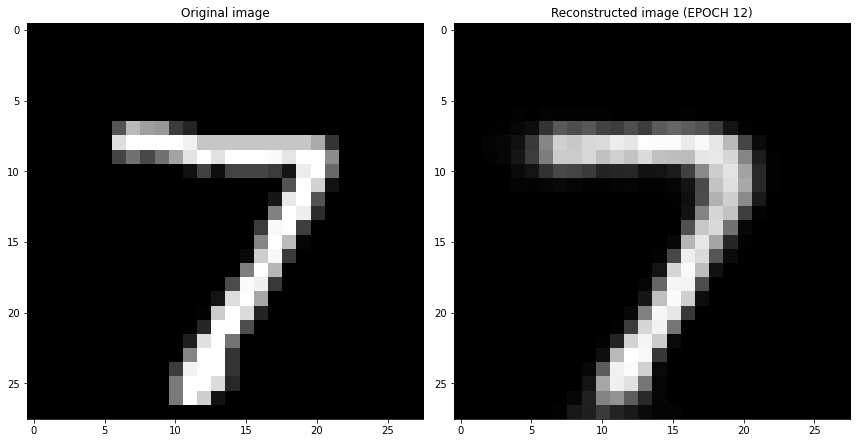

	 TRAIN - EPOCH 13/50 - loss: 0.016470
	 VALIDATION - EPOCH 13/50 - loss: 0.017987


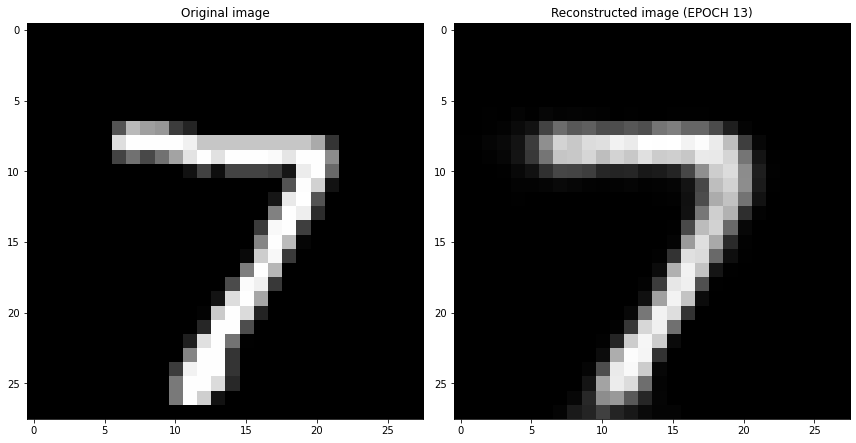

	 TRAIN - EPOCH 14/50 - loss: 0.016192
	 VALIDATION - EPOCH 14/50 - loss: 0.017449


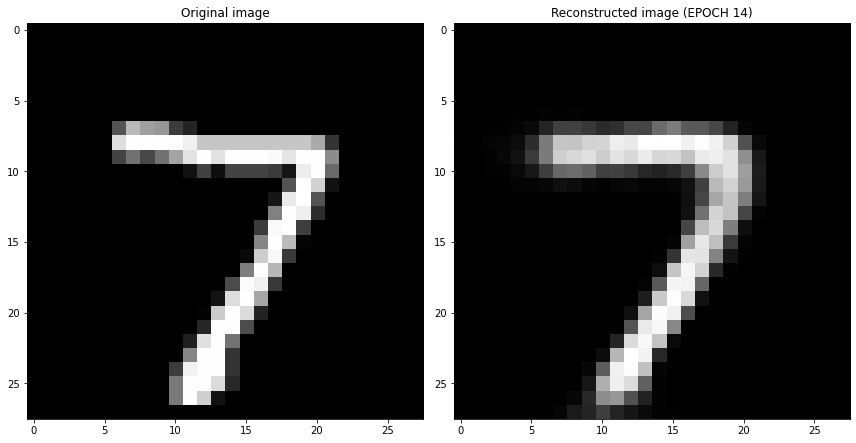

	 TRAIN - EPOCH 15/50 - loss: 0.017167
	 VALIDATION - EPOCH 15/50 - loss: 0.017107


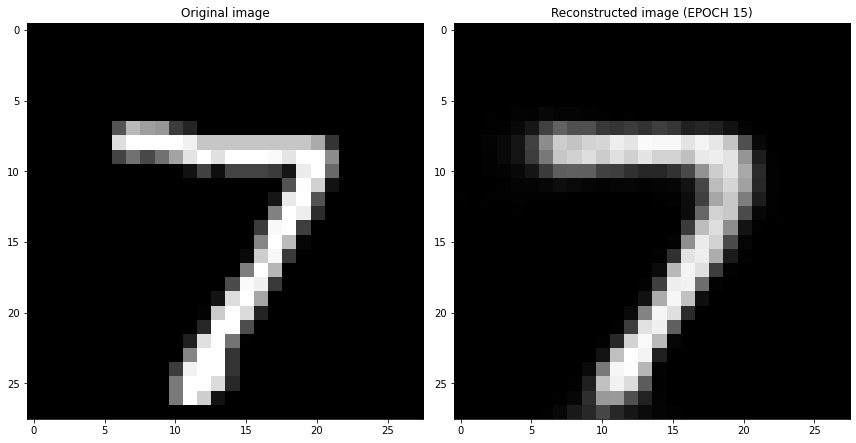

	 TRAIN - EPOCH 16/50 - loss: 0.016588
	 VALIDATION - EPOCH 16/50 - loss: 0.016941


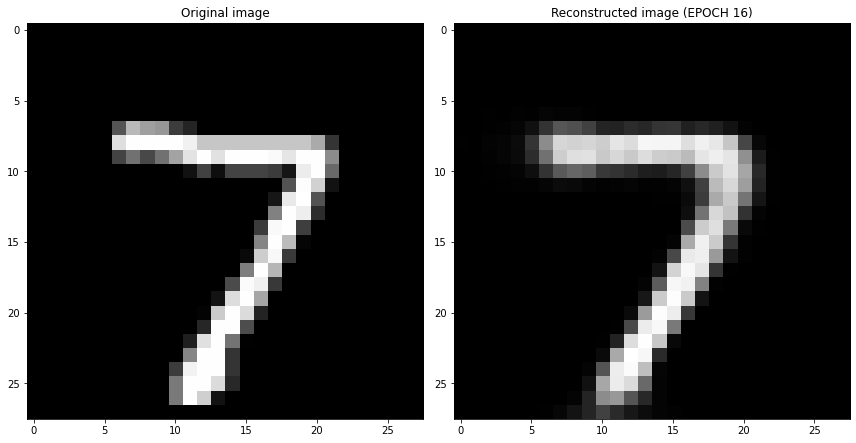

	 TRAIN - EPOCH 17/50 - loss: 0.014944
	 VALIDATION - EPOCH 17/50 - loss: 0.016751


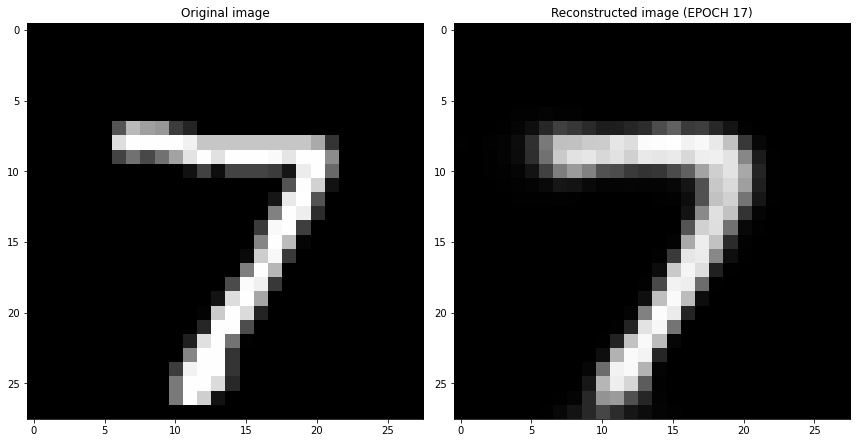

	 TRAIN - EPOCH 18/50 - loss: 0.015929
	 VALIDATION - EPOCH 18/50 - loss: 0.016463


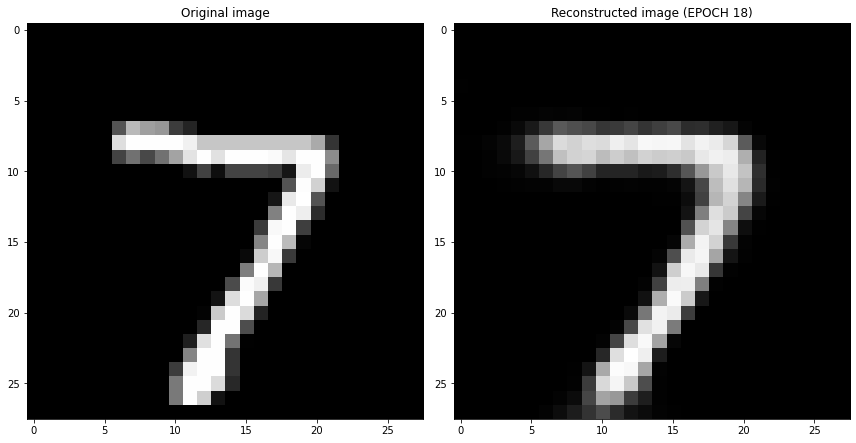

	 TRAIN - EPOCH 19/50 - loss: 0.016081
	 VALIDATION - EPOCH 19/50 - loss: 0.016419


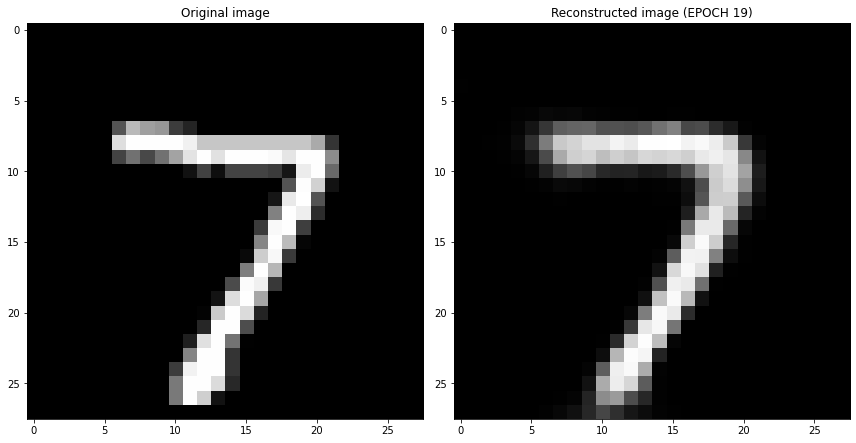

	 TRAIN - EPOCH 20/50 - loss: 0.016189
	 VALIDATION - EPOCH 20/50 - loss: 0.016229


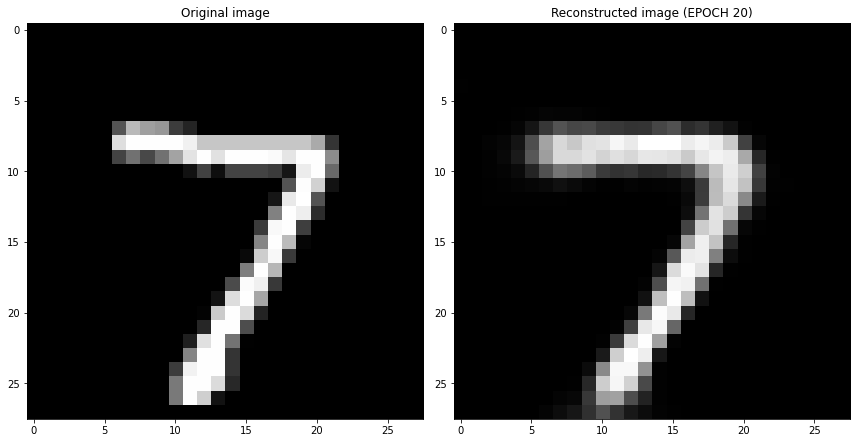

	 TRAIN - EPOCH 21/50 - loss: 0.016987
	 VALIDATION - EPOCH 21/50 - loss: 0.016076


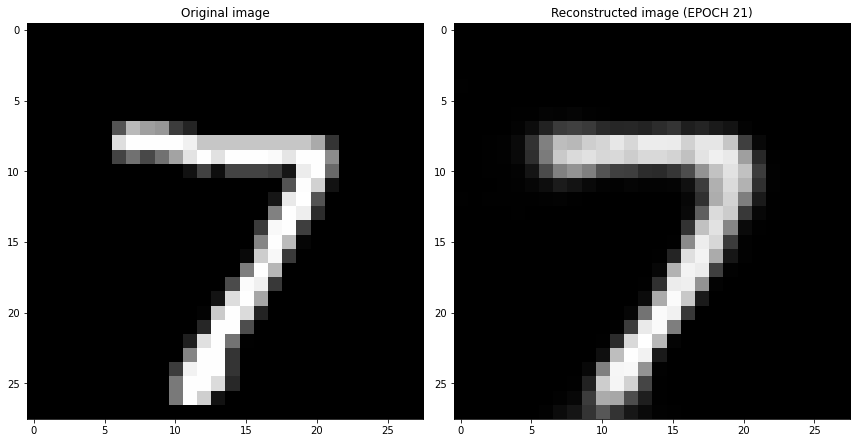

	 TRAIN - EPOCH 22/50 - loss: 0.017495
	 VALIDATION - EPOCH 22/50 - loss: 0.015853


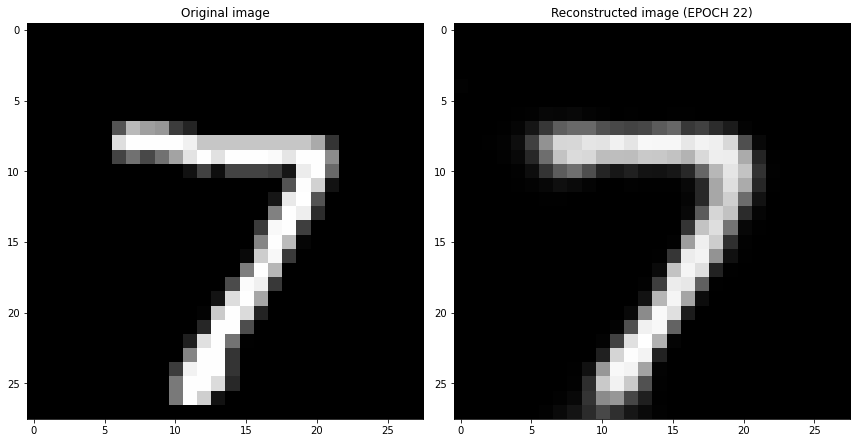

	 TRAIN - EPOCH 23/50 - loss: 0.015296
	 VALIDATION - EPOCH 23/50 - loss: 0.015698


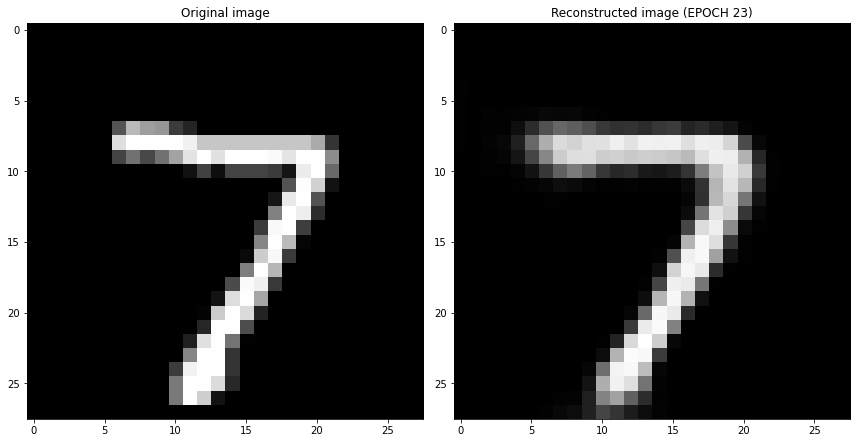

STOPPED BY EARLY STOPPYNG
	Train Loss: 0.015 	Val Loss: 0.016


Best Model: (10, 8, 16, 32, 64, 0.001, 1e-05)


In [14]:
"""
Hyperparams:
encoded_space_dim = [2, 4, 128]
num_epochs=50
early_stopping=5
Conv1=[8,16,32,64]
Conv2=[8,16,32,64]
Conv3=[8,16,32,64]
FC=[32,64,128]
LR=[1e-2,1e-3,1e-4]
L2=[1e-3,1e-4,1e-5]
drop=[0,0.25,0.5,0.75]

"""

space_dim = [10]
num_epochs=50
early_stopping=5
Conv1=[8]
Conv2=[16]
Conv3=[32]
FC=[64]
LR=[1e-3]
L2=[1e-5]
drop=0


hyperparams = [space_dim,Conv1,Conv2,Conv3,FC,LR,L2]  

iterations=[]
import itertools
for hyper in itertools.product(*hyperparams):
    iterations.append(hyper)
print("Total Combinations:",len(iterations))


best_hyper=None
best_loss=None
for i,hyper in enumerate(iterations):
    print("\n\nIteration:",i,hyper)
    encoded_space_dim,conv1,conv2,conv3,fc,lr,l2=hyper
    
    ### Initialize the two networks
    encoder = Encoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)
    decoder = Decoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)

    # Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)

    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)
    
    
    #TRAINING CYCLE
    train_loss_log,val_loss_log=training_cycle(num_epochs,
                                           early_stopping,
                                           encoder,
                                           decoder,
                                           loss_fn,
                                           optim,
                                           train_dataloader,
                                           device,
                                           test_dataset,
                                            noise=False)
    train_loss=train_loss_log[-1]
    val_loss=val_loss_log[-1]
    print("\tTrain Loss:",round(float(train_loss),3),"\tVal Loss:",round(float(val_loss),3))
    
    if not best_loss or val_loss<best_loss:
        best_loss=val_loss
        best_hyper=hyper

        
print("\n\nBest Model:",best_hyper)

## 3.3) Single train

In [ ]:
# Retrain the best model
if best_hyper:
    encoded_space_dim,conv1,conv2,conv3,fc,lr,l2=best_hyper
    print("Training:",best_hyper)


### Initialize the two networks
encoder = Encoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)
decoder = Decoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)

# Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
    
    
train_loss_log,val_loss_log=training_cycle(num_epochs,
                                           early_stopping,
                                           encoder,
                                           decoder,
                                           loss_fn,
                                           optim,
                                           train_dataloader,
                                           device,
                                           test_dataset,
                                           noise=False)

## 3.4) Plot Losses

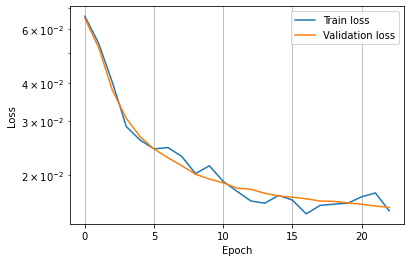

In [16]:
# Plot losses of the best model
plt.figure(figsize=(6,4))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [15]:
test_loss = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn,
            noise=False)

## 3.5) Metric Summary

In [17]:
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]
print("Train Loss:\t",round(float(train_loss),3))
print("Val Loss:\t",round(float(val_loss),3))
print("Test Loss:\t",round(float(test_loss),3))

Train Loss:	 0.015
Val Loss:	 0.016
Test Loss:	 0.016


# 4) Latent Space Visualization and Sample Generation

## 4.1) Latent Space Visualization with T-SNE

In [18]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

In [19]:
### Get the encoded representation of the test samples
encoded_samples = []
labels=[]
for sample in tqdm(test_dataset):
    img = sample[0][0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_samples.append(encoded_img)
    labels.append(str(label))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 914.84it/s]


In [20]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(encoded_samples)

In [21]:
#Plot
#plt.scatter(X_tsne[:,0],X_tsne[:,1],c=labelsint)
#plt.show()
#FAI UN PLOT PIù BELLO

In [22]:
import plotly.express as px
px.scatter(x=X_tsne[:,0], y=X_tsne[:,1], color=labels, opacity=0.7)

## 4.2) Sample Generation

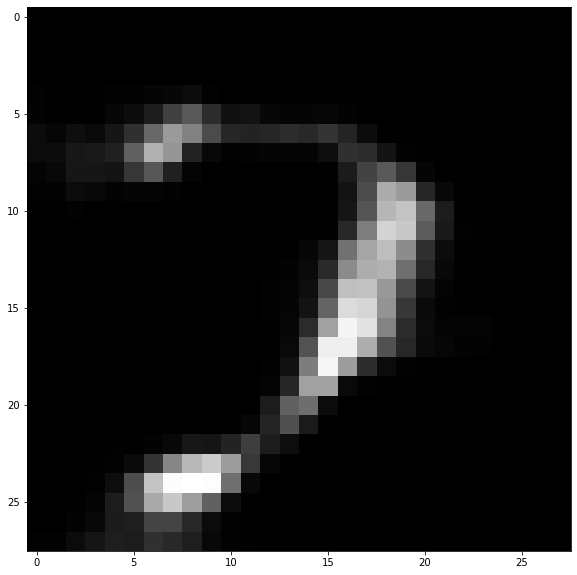

In [28]:
# Generate a custom sample
custom_encoded_sample = [-12,-25,10,-5,31,60,7,8,9,10]
encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

# Decode sample
decoder.eval()
with torch.no_grad():
    generated_img  = decoder(encoded_value)

plt.figure(figsize=(12,10))
plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
plt.show()

---
---
---
# 5) Denoising Autoencoder

In [ ]:
def gaussian_noise(image, noise_factor):
    
    # torch.randn returns random values from a normal with mean 0 and variance 1 -> Gaussian noise!
    noisy_img = image + noise_factor * torch.randn(image.shape)
    #clip the image
    noisy_img = np.clip(noisy_img, 0., 1.)
    
    return noisy_img

## 5.1) Plot some Corrupted images and Recostruction with the normal ConvAE

In [ ]:
corr_imgs, rec_imgs  = [], []

for i in range(10):
    imgc = test_dataset[0][0][0].unsqueeze(0)
    corr_imgs.append(gaussian_noise(imgc, 0.1*i))

for i in range(len(corr_imgs)):
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Move tensor to the proper device
        image_batch = corr_imgs[i].to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Append the network output and the original image to the lists
        rec_imgs.append(decoded_data.cpu())

        
# plot the corrupted input image and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for corr_imgs, row in zip([corr_imgs, rec_imgs], axes):
    for img, ax in zip(corr_imgs, row):
        
        ax.imshow(img.squeeze().cpu().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## 5.2) Train the Denoise AutoEncoder

In [ ]:
# Retrain the best model
"""if best_hyper:
    encoded_space_dim,conv1,conv2,conv3,fc,lr,l2=best_hyper
    print("Training:",best_hyper)"""

encoded_space_dim = 10
num_epochs=50
early_stopping=5
conv1=8
conv2=16
conv3=32
fc=64
lr=1e-3
l2=1e-5
drop=0

### Initialize the two networks
encoder = Encoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)
decoder = Decoder(encoded_space_dim=encoded_space_dim,dropout=drop, conv1=conv1,conv2=conv2,conv3=conv3,fc=fc)

# Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=l2)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
    
    
train_loss_log,val_loss_log=training_cycle(num_epochs,
                                           early_stopping,
                                           encoder,
                                           decoder,
                                           loss_fn,
                                           optim,
                                           train_dataloader,
                                           device,
                                           test_dataset,
                                           noise=True)

In [ ]:
# Plot losses of the best model
plt.figure(figsize=(6,4))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]
print("Train Loss:\t",round(float(train_loss),3))
print("Val Loss:\t",round(float(val_loss),3))

## 5.3) Plot some Corrupted images and Recostruction with the Denoise ConvAE

In [ ]:
corr_imgs, rec_imgs  = [], []

for i in range(10):
    imgc = test_dataset[0][0][0].unsqueeze(0)
    corr_imgs.append(gaussian_noise(imgc, 0.1*i))

for i in range(len(corr_imgs)):
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Move tensor to the proper device
        image_batch = corr_imgs[i].to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Append the network output and the original image to the lists
        rec_imgs.append(decoded_data.cpu())

        
# plot the corrupted input image and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for corr_imgs, row in zip([corr_imgs, rec_imgs], axes):
    for img, ax in zip(corr_imgs, row):
        
        ax.imshow(img.squeeze().cpu().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

---
---
---
---
# 6) Supervised Classification

## 6.1) Split Dataset in Train-Val

In [ ]:
# splliting the trainig dataset into train and validation 
alpha = 0.2
split = int(len(train_dataset) * 0.2)

tr_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [len(train_dataset)-split, split])

print('Samples in training set:',len(tr_dataset))
print('Samples in validation set:',len(val_dataset))

In [ ]:
#apply transformation to train dataset and test dataset
tr_dataset.transform = train_transform
val_dataset.transform = train_transform

#define train dataloader enabling the shuffle of the data
train_dataloader_sup = DataLoader(tr_dataset, batch_size=256, shuffle=True)
#define test dataloader without shuffle the data
val_dataloader_sup = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

## 6.2) Model definition

In [ ]:
print(encoder)

In [ ]:
class_layer = nn.Linear(encoded_space_dim,10)
# Disallow the update of all the layers by setting the 'requires_grad' parameter of the tensors to 'False'
for param_name, param in encoder.named_parameters():
    param.requires_grad = False
    
# Allow the training of the last layers (classifier[4] and classifier[6])
for param in encoder.encoder_lin[2].parameters():
    param.requires_grad = True

for param in encoder.encoder_lin[0].parameters():
    param.requires_grad = True
    
# Check if correct
for param_name, param in encoder.named_parameters():
    print('%s \t- requires_grad=%s' % (param_name, param.requires_grad))

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

#moving both the encoder and the layer for classification to GPU
class_layer.to(device)

# Define the loss function
loss_sup = nn.CrossEntropyLoss()

#optimize the parameters of both the encoder and the layer fot classification
params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': class_layer.parameters()}
    ]

optimizer_sup = torch.optim.Adam(params_to_optimize, lr=1e-3)

## 6.3) Training Functions

In [ ]:
def training_sup(enc, layer, train_dataloader_sup):
  enc.train()
  layer.train()
  for sample_batched in train_dataloader_sup:
      # Move data to device
      x_batch = sample_batched[0][0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      x = enc(x_batch)
      out = layer(x)
      
      # Compute loss
      loss = loss_sup(out, label_batch)

      # Backpropagation
      enc.zero_grad()
      layer.zero_grad()
      loss.backward()

      # Update the weights
      optimizer_sup.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

      #get the accuracy for this batch
      pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
      right = np.sum(pred == np.array(label_batch.cpu()))
      acc_t.append(right)


In [ ]:
def validation_sup(enc, layer, val_dataloader_sup):
  enc.eval()
  layer.eval()
  with torch.no_grad(): # Disable gradient tracking
    for sample_batched in val_dataloader_sup:
      # Move data to device
      x_batch = sample_batched[0][0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      x = enc(x_batch)
      out = layer(x)

      # Compute loss
      loss = loss_sup(out, label_batch)

      # Save val loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      val_loss.append(loss_batch)

      #get the accuracy for the val
      pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
      right = np.sum(pred == np.array(label_batch.cpu()))
      acc_v.append(right)

In [ ]:
 ### TRAINING LOOP
num_epochs = 20
acc_train = 0
acc_val = 0
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
    ### TRAIN
    acc_t = []
    acc_v = []
    train_loss= []
    # Training mode 
    training_sup(encoder, class_layer, train_dataloader_sup)

    # Save average train loss
    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    # Evaluation mode (e.g. disable dropout)
    validation_sup(encoder, class_layer, val_dataloader_sup)

    # Save average validation loss
    val_loss = np.mean(val_loss)
    val_loss_log.append(val_loss)

    acc_train = np.sum(acc_t)/len(tr_dataset)
    acc_val = np.sum(acc_v)/len(val_dataset)
    print("Epoch", epoch_num + 1, "= Average train loss:[", train_loss, "] ","Accuracy train:[", np.round(acc_train,5),"] " ,"Average validation loss: [", val_loss, "]", "Accuracy validation:[",  np.round(acc_val,5),"]")
print("\n")

In [ ]:
# Plot losses
plt.figure(figsize=(6,4))
plt.plot(train_loss_log, label='Train loss')
plt.plot(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

## 6.4) Test the model

In [ ]:
test_loss = []
acc = 0

y_test=[]
y_pred=[]

#move the input to the GPU and predict the output
encoder.eval()
class_layer.eval()
with torch.no_grad(): # No need to track the gradients
    # Define the lists to store the outputs for each batch
    conc_out = []
    conc_label = []
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0][0].to(device)
        y = sample_batched[1].to(device)
        # Encode data
        x = encoder(x_batch)
        out = class_layer(x)

        y_test.append(y)
        y_pred.append(out)

        # Append the network output and the original image to the lists
        loss = loss_sup(out, y)
        test_loss.append(loss.detach().cpu().numpy())

        pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
        right = np.sum(pred == np.array(y.cpu()))
        acc = acc + right

    # Evaluate global loss
    test_loss = np.mean(test_loss)

print("Test loss MODEL:[", float(test_loss),"]", " Accuracy of MODEL:[", np.round(acc/len(test_dataset),5),"]")


## 6.5) Metrics Summary

In [ ]:
train_loss=train_loss_log[-1]
val_loss=val_loss_log[-1]
print("Train Loss:\t",round(float(train_loss),3))
print("Val Loss:\t",round(float(val_loss),3))
print("Test Loss:\t",round(float(test_loss),3))
print("Train Accuracy:\t",round(float(acc_train),3))
print("Val Accuracy:\t",round(float(acc_val),3))
print("Test Accuracy:\t",round(float(acc/len(test_dataset)),3))

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
						  save_path='models/'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=11,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    plt.savefig(save_path+"_picConfMatrix.png", dpi=400)
    plt.tight_layout()

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(pred, y.cpu())
categories=[0,1,2,3,4,5,6,7,8,9]
plot_confusion_matrix(cm,categories, normalize=False,save_path="conf")

---
---
---
---
# 7) Variational Autoencoder

## 7.1) Model

In [9]:
import torch.nn.functional as F

In [10]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [11]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

## 7.2) Train

In [12]:
optimizer = torch.optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [13]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data[0].cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_dataloader.dataset)))

In [14]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_dataloader:
            data = data[0].cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_dataloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [15]:
for epoch in range(1, 51):
    train(epoch)
    test()

C:\Users\stefano\.conda\envs\gputest\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 544.106750
Train Epoch: 1 [25600/60000 (43%)]	Loss: 194.333557
Train Epoch: 1 [51200/60000 (85%)]	Loss: 175.222595
====> Epoch: 1 Average loss: 196.9741
====> Test set loss: 169.1257
Train Epoch: 2 [0/60000 (0%)]	Loss: 170.334808
Train Epoch: 2 [25600/60000 (43%)]	Loss: 165.230194
Train Epoch: 2 [51200/60000 (85%)]	Loss: 161.090485
====> Epoch: 2 Average loss: 164.8489
====> Test set loss: 162.2550
Train Epoch: 3 [0/60000 (0%)]	Loss: 159.809006
Train Epoch: 3 [25600/60000 (43%)]	Loss: 163.404739
Train Epoch: 3 [51200/60000 (85%)]	Loss: 163.629288
====> Epoch: 3 Average loss: 158.8188
====> Test set loss: 157.3823
Train Epoch: 4 [0/60000 (0%)]	Loss: 158.419449
Train Epoch: 4 [25600/60000 (43%)]	Loss: 154.706207
Train Epoch: 4 [51200/60000 (85%)]	Loss: 154.189758
====> Epoch: 4 Average loss: 155.0948
====> Test set loss: 153.9298
Train Epoch: 5 [0/60000 (0%)]	Loss: 157.148376
Train Epoch: 5 [25600/60000 (43%)]	Loss: 148.246338
Train Epoch: 5 [51200/600

Train Epoch: 38 [25600/60000 (43%)]	Loss: 138.831909
Train Epoch: 38 [51200/60000 (85%)]	Loss: 134.036804
====> Epoch: 38 Average loss: 137.6004
====> Test set loss: 140.5022
Train Epoch: 39 [0/60000 (0%)]	Loss: 139.215652
Train Epoch: 39 [25600/60000 (43%)]	Loss: 141.708755
Train Epoch: 39 [51200/60000 (85%)]	Loss: 135.683701
====> Epoch: 39 Average loss: 137.1086
====> Test set loss: 140.0276
Train Epoch: 40 [0/60000 (0%)]	Loss: 139.851944
Train Epoch: 40 [25600/60000 (43%)]	Loss: 135.848389
Train Epoch: 40 [51200/60000 (85%)]	Loss: 134.480988
====> Epoch: 40 Average loss: 136.8667
====> Test set loss: 139.8886
Train Epoch: 41 [0/60000 (0%)]	Loss: 136.433380
Train Epoch: 41 [25600/60000 (43%)]	Loss: 138.222702
Train Epoch: 41 [51200/60000 (85%)]	Loss: 139.446106
====> Epoch: 41 Average loss: 136.9381
====> Test set loss: 139.8036
Train Epoch: 42 [0/60000 (0%)]	Loss: 138.914291
Train Epoch: 42 [25600/60000 (43%)]	Loss: 132.536118
Train Epoch: 42 [51200/60000 (85%)]	Loss: 130.450577
==

## 7.3) Generate some samples from the VAE

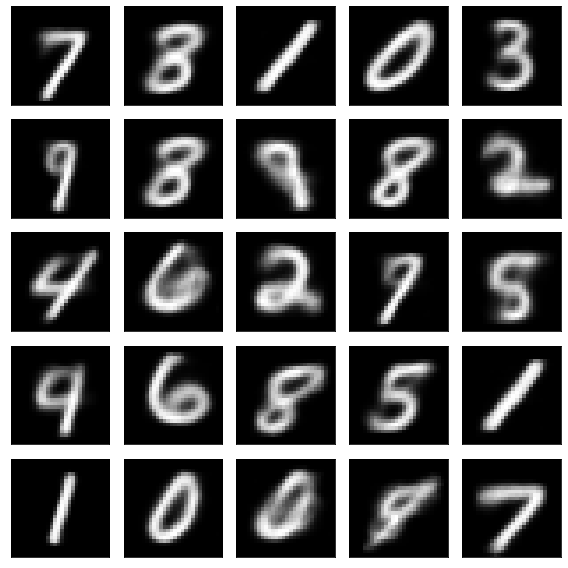

In [16]:
### Plot some sample
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    with torch.no_grad():
        z = torch.randn(1, 2).cuda()
        sample = vae.decoder(z).cuda()
    sample=sample.view(1, 1, 28, 28)[0].cpu().squeeze().numpy()
    
    ax.imshow(sample, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()